In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
tra = pd.read_csv('gdrive/My Drive/indiana_reports.csv')
tra.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [ ]:
#txt[txt['findings'].isna()]
txt = tra[['Problems', 'findings']]
txt = txt.rename(columns={"Problems":"y", "findings":"text"})
txt.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
1,Cardiomegaly;Pulmonary Artery,Borderline cardiomegaly. Midline sternotomy XX...
2,normal,NaN
3,"Pulmonary Disease, Chronic Obstructive;Bullous...",There are diffuse bilateral interstitial and a...
4,Osteophyte;Thickening;Lung,The cardiomediastinal silhouette and pulmonary...


In [ ]:
## filter categories   ##'Pulmonary Atelectasis','Implanted Medical Device', 'Foreign Bodies', 'Atherosclerosis', 
txt = txt[txt["y"].isin(['normal','Calcified Granuloma','Calcinosis','Opacity','Cardiomegaly','Spondylosis',
                         'Granulomatous Disease', 'Osteophyte', 'Fractures, Bone'])][["y","text"]]
txt.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
2,normal,NaN
5,normal,Heart size and mediastinal contour are within ...
7,normal,"The heart, pulmonary XXXX and mediastinum are ..."
9,Calcified Granuloma,The cardiomediastinal silhouette is within nor...


In [ ]:
df = txt[pd.notnull(txt['text'])].reset_index()
df.head()

,index,y,text
0,0,normal,The cardiac silhouette and mediastinum size ar...
1,5,normal,Heart size and mediastinal contour are within ...
2,7,normal,"The heart, pulmonary XXXX and mediastinum are ..."
3,9,Calcified Granuloma,The cardiomediastinal silhouette is within nor...
4,10,normal,Cardiomediastinal silhouette and pulmonary vas...


In [ ]:
df = df[['text', 'y']]
df.head()

,text,y
0,The cardiac silhouette and mediastinum size ar...,normal
1,Heart size and mediastinal contour are within ...,normal
2,"The heart, pulmonary XXXX and mediastinum are ...",normal
3,The cardiomediastinal silhouette is within nor...,Calcified Granuloma
4,Cardiomediastinal silhouette and pulmonary vas...,normal


In [ ]:
num_classes = len(df["y"].value_counts())
print(num_classes)

9


In [ ]:
# map topic descriptions to labels
df['labels'] = df['y'].map({'normal': 0,
                            'Calcified Granuloma': 1,
                            'Calcinosis': 3,
                            'Opacity': 3,
                            'Cardiomegaly': 4,
                            'Spondylosis': 5,
                            'Granulomatous Disease': 6, 
                            'Osteophyte': 7, 
                            'Fractures, Bone': 8})

# drop unused column
df = df.drop(["y"], axis=1)

df.head()

,text,labels
0,The cardiac silhouette and mediastinum size ar...,0
1,Heart size and mediastinal contour are within ...,0
2,"The heart, pulmonary XXXX and mediastinum are ...",0
3,The cardiomediastinal silhouette is within nor...,1
4,Cardiomediastinal silhouette and pulmonary vas...,0


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
    '''return BERT-like embeddings of input text
    
    Args:
    - sentences: list of strings
    
    Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
    '''
    preprocessed_text = preprocessor(sentences)
    
    return encoder(preprocessed_text)['pooled_output']


get_embeddings([ "The cardiac organ silhouette and mediastinum multi-tissue-structure size are within normal limits."])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-2.75707811e-01, -1.11490391e-01, -5.06482244e-01,
        -1.68939918e-01,  2.44526431e-01,  5.91304675e-02,
        -7.63752609e-02, -4.72840548e-01, -5.33251278e-02,
        -5.95856667e-01, -4.00176227e-01, -5.71791470e-01,
         6.76000863e-02, -3.02235931e-01, -5.94532847e-01,
        -5.85097134e-01,  8.77318829e-02, -1.71016499e-01,
         5.42432666e-01, -2.97547549e-01, -3.84585232e-01,
        -1.09776713e-01,  3.72404993e-01,  5.09244561e-01,
        -4.80643839e-01, -6.34411931e-01,  2.35681504e-01,
        -4.17816460e-01, -1.95611119e-01, -5.00633299e-01,
        -7.90529549e-02, -3.64533037e-01, -3.10651124e-01,
        -5.25836587e-01, -2.76452184e-01,  4.11757827e-02,
        -2.94563234e-01,  2.30021402e-02, -2.07734466e-01,
        -3.57203305e-01, -3.63919824e-01, -2.40477398e-01,
        -2.32404903e-01, -9.93260518e-02, -9.46421623e-01,
         2.41751835e-01,  1.52965739e-01, -4.79671717e-01,
      

In [ ]:
import seaborn as sns
import matplotlib as plt
import sys
import pylab as pl
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
    """Plot a similarity matrix of the embeddings."""
    cos_sim = cosine_similarity(features)
    
    fig = pl.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    
    cbar_kws=dict(use_gridspec=False, location="left")
    g = sns.heatmap(cos_sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, 
                    annot=True, cmap="Blues", cbar_kws=cbar_kws)
    
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title("Semantic Textual Similarity")

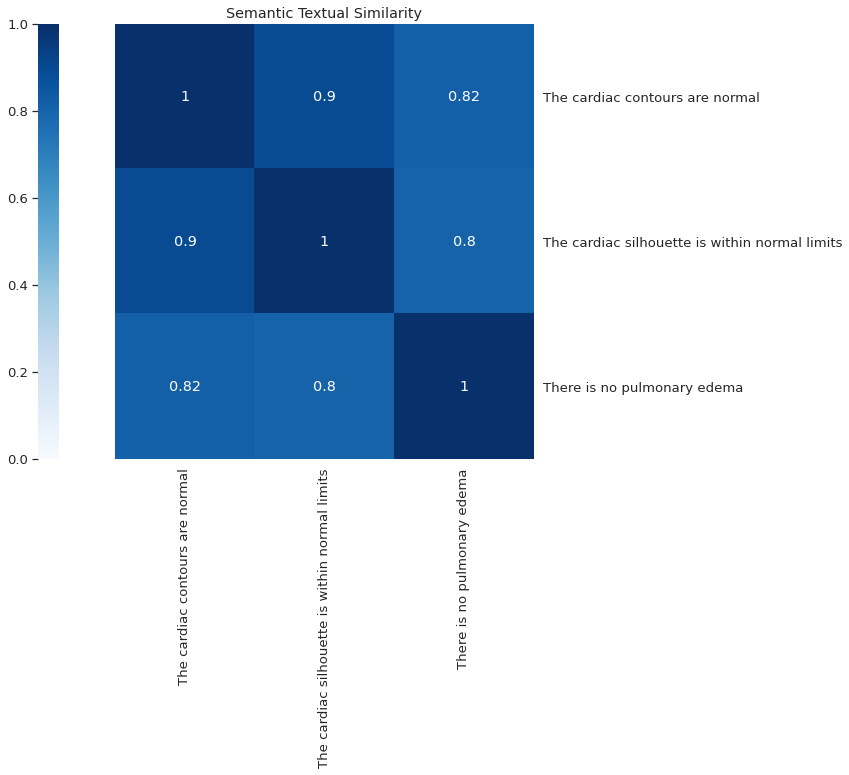

In [ ]:
reviews = ["The cardiac contours are normal",
           "The cardiac silhouette is within normal limits",
           "There is no pulmonary edema"]

plot_similarity(get_embeddings(reviews), reviews)

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 20

METRICS = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),balanced_recall,
           balanced_precision, balanced_f1_score]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,restore_best_weights = True)

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = METRICS)

model_fit = model.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
34/34 [==============================] - 68s 975ms/step - loss: 0.8454 - accuracy: 0.8201 - balanced_recall: 0.0944 - balanced_precision: 0.0890 - balanced_f1_score: 0.0880 - val_loss: 0.7195 - val_accuracy: 0.8258 - val_balanced_recall: 0.1111 - val_balanced_precision: 0.0911 - val_balanced_f1_score: 0.1000
Epoch 2/20
34/34 [==============================] - 28s 837ms/step - loss: 0.5920 - accuracy: 0.8472 - balanced_recall: 0.1111 - balanced_precision: 0.0944 - balanced_f1_score: 0.1019 - val_loss: 0.6250 - val_accuracy: 0.8258 - val_balanced_recall: 0.1111 - val_balanced_precision: 0.0916 - val_balanced_f1_score: 0.1003
Epoch 3/20
34/34 [==============================] - 29s 847ms/step - loss: 0.5313 - accuracy: 0.8538 - balanced_recall: 0.1238 - balanced_precision: 0.1121 - balanced_f1_score: 0.1171 - val_loss: 0.5575 - val_accuracy: 0.8343 - val_balanced_recall: 0.1188 - val_balanced_precision: 0.1127 - val_balanced_f1_score: 0.1145
Epoch 4/20
34/34 [===================

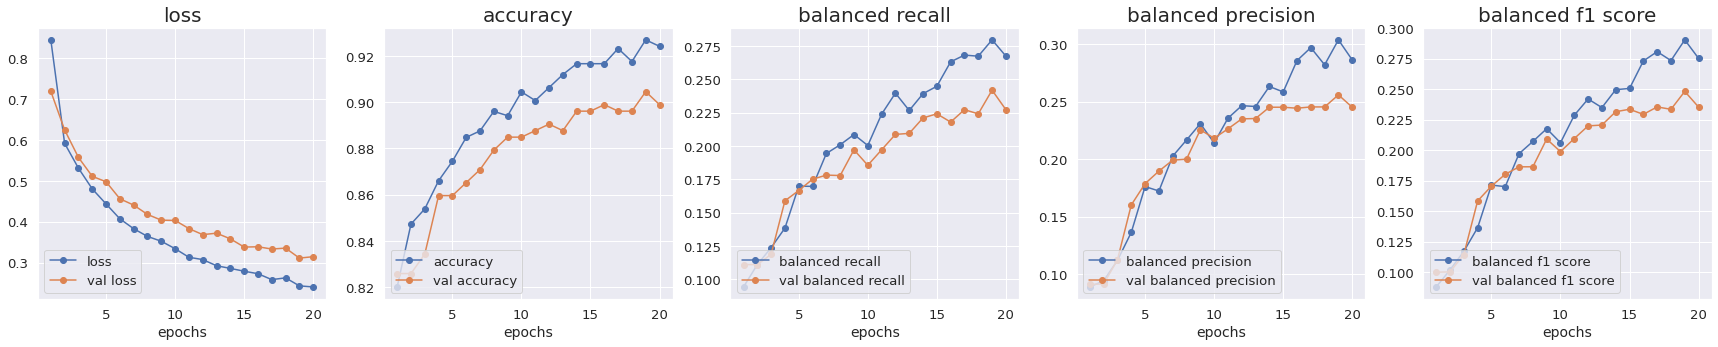

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = pl.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

prediction = model.predict(x_test)

prediction = np.argmax(prediction, axis=1)
y_test = np.argmax(y_test, axis = 1)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       294
           1       0.90      0.72      0.80        25
           3       0.75      0.25      0.38        12
           4       0.00      0.00      0.00         3
           5       1.00      1.00      1.00         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         9

    accuracy                           0.90       356
   macro avg       0.57      0.41      0.45       356
weighted avg       0.85      0.90      0.87       356



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()